In [1]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from numpy import *
import glob
import scipy 
from datetime import datetime as dt
import sklearn
sns.style = 'darkgrid'

In [2]:
def convert_stress(level):
    """
    converts input stress level from the scale above into a more usable scale with 1 being feeling great 
    and 5 being stressed out.
    """
    # little stress = 3/5 stressed
    if level == 1: 
        return 3
    # definitely stressed = 4/5
    if level == 2:
        return 4
    # stressed out = 5/5
    if level == 3:
        return 5
    # feeling good = 2/5
    if level == 4: 
        return 2
    # feeling great = 1/5 
    if level == 5:
        return 1
    else:
        return 0

In [3]:
def convert_PAM(level):
    """
    assigns PAM picture_idx levels to four ranges (four quadrants):
    Quadrant 1: negative valence and low arousal; Quadrant 2: negative valence and high arousal; 
    Quadrant 3: positive valence and low arousal; Quadrant 4: positive valence and high arousal
    """
    quadrant_1 = list(range(1,5))
    quadrant_2 = list(range(5,9))
    quadrant_3 = list(range(9,13))
    quadrant_4 = list(range(13,17))
    
    if level in quadrant_1:
        return 1
    if level in quadrant_2: 
        return 2
    if level in quadrant_3: 
        return 3
    if level in quadrant_4: 
        return 4

In [4]:
def location_variance(gps_df):
    """
    returns the location variance of the gps dataframe, which is log(variance of latitiude squared plus variance of 
    longitude squared)
    """
    num =  gps_df['lon'].var() + gps_df['lat'].var()
    return log(num)

In [5]:
def process_stress_ema_remove_null(uid, ema_name, desired_column): 
    """
    input: uid for which we want to process the stress EMA
    """
    #ema = pd.read_json('dataset/dataset/EMA/response/{}/{}_{}.json'.format(ema_name, ema_name, uid))
    ema = pd.read_json('dataset/dataset/EMA/response/'+ ema_name + '/' + ema_name + '_' + uid + '.json')

    try: 
        ema[desired_column] = ema[desired_column].where(np.isfinite, ema.null)
    except: 
        pass

        
    ema[desired_column] = pd.to_numeric(ema[desired_column], errors='coerce')
    
    ema = ema[['resp_time', desired_column]]
    ema = ema.dropna()
    
    if ema_name == 'stress': 
        ema['level'] = ema['level'].apply(convert_stress)
    if ema_name == 'PAM':
        ema['picture_idx'] = ema['picture_idx'].apply(convert_PAM)
    
    return ema

In [6]:
process_stress_ema_remove_null('u07', 'PAM', 'picture_idx')

,resp_time,picture_idx
0,2013-03-30 20:27:43,4
1,2013-03-24 10:48:05,2
2,2013-03-24 10:48:09,3
3,2013-03-24 09:56:55,2
4,2013-04-02 12:21:39,4
...,...,...
142,2013-04-26 02:27:06,3
143,2013-04-29 22:00:39,4
144,2013-04-28 22:22:40,4
145,2013-04-29 08:10:30,4


In [7]:
def num_changes(wifi_locations): 
    changes = -1
    previous = None
    
    for location in wifi_locations['location'].values: 
        if location != previous:
            changes += 1
            previous = location
        else: 
            continue
            
    return changes

In [8]:
def time_in_range(start, end, x):
    """Return true if x is in the range [start, end]"""
    if start <= end:
        return start <= x <= end
    else:
        return start <= x or x <= end

In [9]:
def load_activity(uid): 
    # load activity data
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity['time'] = pd.to_datetime(activity['timestamp'], unit = 's') 
    activity['day'] = activity['time'].dt.dayofyear
    activity = activity[activity[' activity inference'] != 3]
    return activity

def load_conversation(uid): 
    # load conversation data
    conversation = pd.read_csv('dataset/dataset/sensing/conversation/conversation_' + uid + '.csv')
    conversation['convo duration'] = conversation[' end_timestamp'] - conversation['start_timestamp']
    conversation['day'] = pd.to_datetime(conversation['start_timestamp'], unit = 's').dt.dayofyear
    return conversation

def load_darkness(uid): 
    # load darkness data
    darkness = pd.read_csv('dataset/dataset/sensing/dark/dark_' + uid + '.csv')
    darkness['day'] = pd.to_datetime(darkness['start'], unit = 's').dt.dayofyear
    darkness['duration'] = darkness['end'] - darkness['start']
    return darkness

def load_bluetooth(uid):
    # load bluetooth data
    bluetooth = pd.read_csv('dataset/dataset/sensing/bluetooth/bt_' + uid + '.csv')
    bluetooth['time'] = pd.to_datetime(bluetooth['time'], unit = 's')
    bluetooth['day'] = bluetooth['time'].dt.dayofyear
    return bluetooth

def load_gps(uid):
    # gps data 
    gps = pd.read_csv('dataset/dataset/sensing/gps/gps_' + uid + '.csv')
    # data is out of order, this will reformat it. 
    gps.reset_index(inplace = True)
    gps.columns = ('timestamp', 'provider', 'network_type', 'accuracy', 'lat',
                   'lon', 'altitude', 'bearing' ,'speed', 'travelstate', 'null')
    gps = gps.drop("null", 1)
    gps['time'] = pd.to_datetime(gps['timestamp'], unit = 's')
    gps['day'] = gps['time'].dt.dayofyear
    return gps

def load_wifi_locations(uid): 
    # wifi locations data
    wifi_locations = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    wifi_locations.reset_index(inplace = True)
    wifi_locations.columns = ("timestamp", "location", "null")
    wifi_locations = wifi_locations.drop("null", 1)
    wifi_locations['time'] = pd.to_datetime(wifi_locations['timestamp'], unit = 's')
    wifi_locations['day'] = wifi_locations['time'].dt.dayofyear
    return wifi_locations

def load_sms(uid):
    sms = pd.read_csv('dataset/dataset/sms/sms_' + uid + '.csv')
    sms['time'] = pd.to_datetime(sms['timestamp'], unit='s')
    sms['day'] = sms['time'].dt.dayofyear
    return sms

def load_phone_lock(uid):
    phone_lock = pd.read_csv('dataset/dataset/sensing/phonelock/phonelock_' + uid + '.csv')
    phone_lock = phone_lock.rename(columns={'start': 'start_timestamp', 'end': 'end_timestamp'})
    phone_lock['lock dur'] = phone_lock['end_timestamp'] - phone_lock['start_timestamp']
    phone_lock['day'] = pd.to_datetime(phone_lock['start_timestamp'], unit='s').dt.dayofyear
    phone_lock['start_day'] = phone_lock['day']
    phone_lock['end_day'] = pd.to_datetime(phone_lock['end_timestamp'], unit='s').dt.dayofyear
    return phone_lock

def load_app_usage(uid):
    app_usage = pd.read_csv('dataset/dataset/app_usage/running_app_' + uid + '.csv')
    app_usage['time'] = pd.to_datetime(app_usage['timestamp'], unit='s')
    app_usage['day'] = app_usage['time'].dt.dayofyear
    return app_usage

In [10]:
def conversation_in_range(time_interval, convo_df, start_name, end_name): 
    """
    inputs: 
        time_interval -- formatted as (start time, end time, start day, end day)
        convo_df -- a dataframe containing start and end timestamps for a duration measurement 
            (so this function can be used for darkness as well as conversation)
        start_name -- name of the column indicating the start timestamp
        end_name -- name of the column indicating the end timestamp. 
    outputs: 
        the total conversation duration in the time interval.
        
    Note -- I initially named this function for activity so the variable names reflect that, but it can be applied to
    multiple sensor data. 
    
    This function is is similar to the activity in range but applies to dataframes contianing durations so the approach is
    slightly different.  
    """
    # again, unpack interval. 
    start = time_interval[0]
    end = time_interval[1]
    start_day = time_interval[2]
    end_day = time_interval[3]
    
    # look at relevant days 
    if start_day == end_day: 
        conv = convo_df[convo_df['day'] == start_day]
    else: 
        conv = convo_df[convo_df['day'] == start_day].append(convo_df[convo_df['day'] == end_day])
  
    # turn the conversations into intervals. If none exist, the duration is 0. 
    #try:
    conv['interval'] = list(zip(pd.to_datetime(conv[start_name], unit = 's'), 
                                    pd.to_datetime(conv[end_name], unit = 's')))
    #except:
        #return 0

    
    # this function returns the duration of conversation inside the desired interval for each time interval. 
    conv['desired duration'] = conv['interval'].apply(lambda x: conv_range(start, end, x))
    conv = conv.dropna()
    
    # return the sum of all desired intervals. 

    return conv['desired duration'].sum()

In [11]:
def conv_range(start, end, conv_interval): 
    """
    returns the amount of seconds of conversation are in the interval (start, end)
    """
    conv_start = conv_interval[0]
    conv_end = conv_interval[1]
    
    if conv_end < start: 
        return np.nan
    
    elif conv_start > end:
        return np.nan
    
    elif conv_start >= start and conv_end >= end:
        return end - conv_start 
    
    elif conv_start <= start and conv_end <= end:
        return conv_end - start
    
    elif conv_start >= start and conv_end <= end:
        return conv_end - conv_start
    
    elif conv_start <= start and conv_end >= end:
        return end - start
    
def convert_timedeltas(x): 
    """
    converts timedeltas to seconds, leaves any numbers
    """
    try:
        return x.seconds
    except:
        return x 

In [12]:
def activity_in_range(time_interval, activity_df, func = 'act'): 
    """
    inputs: 
        time_interval -- formatted as (start time, end time, start day, end day)
        activity_df -- dataframe for a single user. 
    outputs: 
        the mean activity inference in the time interval.
        
    Note: the activity dataframe and variable names imply 
    """
    
    # unpack the values from the time interval
    start = time_interval[0]
    end = time_interval[1]
    start_day = time_interval[2]
    end_day = time_interval[3]
    
    # only look at relevant days to say runtime
    if start_day == end_day: 
        activity = activity_df[activity_df['day'] == start_day]
    else: 
        activity = activity_df[activity_df['day'] == start_day].append(activity_df[activity_df['day'] == end_day])
        
    # this try except loop takes care of the case where the activity data is an empty dataframe, so we return Nan 
    try: 
        ### these cases are different for different func inputs so this function can be extensible. 
        
        # in this case, we are looking at activity and taking the mean
        if func == 'act':
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].sum()
        elif func == 'all_act': 
            print(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].values)
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))][' activity inference'].values
        # in this case, we are looking at bluetooth and take the count
        elif func == 'count':
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))].shape[0]
        # in this case we apply the location variance function 
        elif func == 'location variance': 
            return location_variance(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))])
        elif func == 'location changes': 
            return num_changes(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))])
    except:
        # if we find none in count, we return 0. If not, there is no data/average from there so return Nan. 
        if func == 'count': 
            return 0
        return np.nan

In [13]:
load_phone_lock('u59').columns

Index(['start_timestamp', 'end_timestamp', 'lock dur', 'day', 'start_day',
       'end_day'],
      dtype='object')

In [14]:
def phone_lock_in_range(time_interval, activity_df, start_name, end_name, func = 'act'): 
    """
    inputs: 
        time_interval -- formatted as (start time, end time, start day, end day)
        activity_df -- dataframe for a single user. 
    outputs: 
        the mean activity inference in the time interval.
        
    Note: the activity dataframe and variable names imply 
    """
    
    # unpack the values from the time interval
    start = time_interval[0]
    end = time_interval[1]
    start_day = time_interval[2]
    end_day = time_interval[3]
    
    # only look at relevant days to say runtime
    if start_day == end_day: 
        activity = activity_df[activity_df['day'] == start_day]
    else: 
        activity = activity_df[activity_df['day'] == start_day].append(activity_df[activity_df['day'] == end_day])
        
    # this try except loop takes care of the case where the activity data is an empty dataframe, so we return Nan 
    try: 
        ### these cases are different for different func inputs so this function can be extensible. 
        
        # in this case, we are looking at activity and taking the mean
        if func == 'act':
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))]['lock dur'].sum()
        elif func == 'all_act': 
            print(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))]['lock dur'].values)
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))]['lock dur'].values
        # in this case, we are looking at bluetooth and take the count
        elif func == 'count':
            return activity[activity['time'].apply(lambda x: time_in_range(start, end, x))].shape[0]
        # in this case we apply the location variance function 
        elif func == 'location variance': 
            return location_variance(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))])
        elif func == 'location changes': 
            return num_changes(activity[activity['time'].apply(lambda x: time_in_range(start, end, x))])
    except:
        # if we find none in count, we return 0. If not, there is no data/average from there so return Nan. 
        if func == 'count': 
            return 0
        return np.nan

In [15]:
#This function returns a new dataframe with all of the activity durations for a particular student throughout the term.
#Only activities longer than 1 minute were considered.
#At the end, we dediced to use total activity duration (sum of activity durations per day) for our model

def activity_analysis(uid):
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity = activity[activity[' activity inference'] !=3]
    activity = activity.reset_index()
    #Change the path as needed when running the files on your computer.
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    def shift_counter_activity(data):
        shift_num = 0
        list_shift_num = []
        list_time = []
        list_day = []
        for i in range(0, len(data)):
            if data[' activity inference'][i] != 0:
                try: 
                    if data[' activity inference'][i+1] != 0 and (data.index[i]+1) == data.index[i+1]:
                        shift_num += 1
                    else:
                        list_shift_num.append(shift_num)
                        shift_num = 0
                except:
                    list_shift_num.append(shift_num)
                    shift_num = 0
        return list_shift_num
    activity_shifts = shift_counter_activity(activity)
    edited_act = activity[activity[' activity inference'] !=0]
    edited_act = edited_act.reset_index()
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    new_activity_shifts = shifts_only(activity_shifts)
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before_activity = get_sums(activity_shifts)
    def activity_dur(list_shift_num, data):
        time_deltas = []
        day = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]] - data['timestamp'][0])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
            elif i != 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - data['timestamp'][list_sums_before_activity[i]+i])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
        dataframe = pd.DataFrame({'Time Delta': time_deltas, 'day': day, 'Start Time': start_time})
        return dataframe
    activity_dur_df = activity_dur(activity_shifts, edited_act)
    activity_dur_df['end_time'] = activity_dur_df['Start Time'] + activity_dur_df['Time Delta']
    activity_dur_df['start_day'] = pd.to_datetime(activity_dur_df['Start Time'], unit='s').dt.dayofyear
    activity_dur_df['end_day'] = pd.to_datetime(activity_dur_df['end_time'], unit='s').dt.dayofyear
    activity_dur_df = activity_dur_df.rename(columns={'Start Time': 'start_time'})
    #activity_dur_df = activity_dur_df[activity_dur_df['Time Delta'] >= 60]
    activity_dur_day = activity_dur_df.groupby('day')['Time Delta'].sum()
    return activity_dur_df

In [16]:
#This function returns a new dataframe with all of the activity durations for a particular student throughout the term.
#Only activities longer than 1 minute were considered.
#At the end, we dediced to use total activity duration (sum of activity durations per day) for our model

def activity_analysis_walking(uid):
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity = activity[activity[' activity inference'] !=3]
    activity = activity[activity[' activity inference'] !=2]
    activity = activity.reset_index()
    #Change the path as needed when running the files on your computer.
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    def shift_counter_activity(data):
        shift_num = 0
        list_shift_num = []
        list_time = []
        list_day = []
        for i in range(0, len(data)):
            if data[' activity inference'][i] != 0:
                try: 
                    if data[' activity inference'][i+1] != 0 and (data.index[i]+1) == data.index[i+1]:
                        shift_num += 1
                    else:
                        list_shift_num.append(shift_num)
                        shift_num = 0
                except:
                    list_shift_num.append(shift_num)
                    shift_num = 0
        return list_shift_num
    activity_shifts = shift_counter_activity(activity)
    edited_act = activity[activity[' activity inference'] !=0]
    edited_act = edited_act.reset_index()
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    new_activity_shifts = shifts_only(activity_shifts)
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before_activity = get_sums(activity_shifts)
    def activity_dur(list_shift_num, data):
        time_deltas = []
        day = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]] - data['timestamp'][0])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
            elif i != 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - data['timestamp'][list_sums_before_activity[i]+i])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
        dataframe = pd.DataFrame({'Time Delta': time_deltas, 'day': day, 'Start Time': start_time})
        return dataframe
    activity_dur_df = activity_dur(activity_shifts, edited_act)
    activity_dur_df['end_time'] = activity_dur_df['Start Time'] + activity_dur_df['Time Delta']
    activity_dur_df['start_day'] = pd.to_datetime(activity_dur_df['Start Time'], unit='s').dt.dayofyear
    activity_dur_df['end_day'] = pd.to_datetime(activity_dur_df['end_time'], unit='s').dt.dayofyear
    activity_dur_df = activity_dur_df.rename(columns={'Start Time': 'start_time'})
    #activity_dur_df = activity_dur_df[activity_dur_df['Time Delta'] >= 60]
    activity_dur_day = activity_dur_df.groupby('day')['Time Delta'].sum()
    return activity_dur_df

In [17]:
#This function returns a new dataframe with all of the activity durations for a particular student throughout the term.
#Only activities longer than 1 minute were considered.
#At the end, we dediced to use total activity duration (sum of activity durations per day) for our model

def activity_analysis_running(uid):
    activity = pd.read_csv('dataset/dataset/sensing/activity/activity_' + uid + '.csv')
    activity = activity[activity[' activity inference'] !=3]
    activity = activity[activity[' activity inference'] !=1]
    activity = activity.reset_index()
    #Change the path as needed when running the files on your computer.
    activity['day'] = pd.to_datetime(activity['timestamp'], unit = 's').dt.dayofyear
    daily_activity = activity.groupby('day').mean()
    
    def shift_counter_activity(data):
        shift_num = 0
        list_shift_num = []
        list_time = []
        list_day = []
        for i in range(0, len(data)):
            if data[' activity inference'][i] != 0:
                try: 
                    if data[' activity inference'][i+1] != 0 and (data.index[i]+1) == data.index[i+1]:
                        shift_num += 1
                    else:
                        list_shift_num.append(shift_num)
                        shift_num = 0
                except:
                    list_shift_num.append(shift_num)
                    shift_num = 0
        return list_shift_num
    activity_shifts = shift_counter_activity(activity)
    edited_act = activity[activity[' activity inference'] !=0]
    edited_act = edited_act.reset_index()
    
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    new_activity_shifts = shifts_only(activity_shifts)
    
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before_activity = get_sums(activity_shifts)
    
    def activity_dur(list_shift_num, data):
        time_deltas = []
        day = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]] - data['timestamp'][0])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
            elif i != 0:
                time_deltas.append(data['timestamp'][list_shift_num[i]+i+list_sums_before_activity[i]] - data['timestamp'][list_sums_before_activity[i]+i])
                day.append(data.day[list_shift_num[i]+i+list_sums_before_activity[i]])
                start_time.append(data.timestamp[list_shift_num[i]+i+list_sums_before_activity[i]])
        dataframe = pd.DataFrame({'Time Delta': time_deltas, 'day': day, 'Start Time': start_time})
        return dataframe
    
    activity_dur_df = activity_dur(activity_shifts, edited_act)
    activity_dur_df['end_time'] = activity_dur_df['Start Time'] + activity_dur_df['Time Delta']
    activity_dur_df['start_day'] = pd.to_datetime(activity_dur_df['Start Time'], unit='s').dt.dayofyear
    activity_dur_df['end_day'] = pd.to_datetime(activity_dur_df['end_time'], unit='s').dt.dayofyear
    activity_dur_df = activity_dur_df.rename(columns={'Start Time': 'start_time'})
    #activity_dur_df = activity_dur_df[activity_dur_df['Time Delta'] >= 60]
    activity_dur_day = activity_dur_df.groupby('day')['Time Delta'].sum()
    
    return activity_dur_df

In [18]:
def deadlines_processing():
    data = pd.read_csv('dataset/dataset/education/deadlines.csv')
    data = data.dropna(axis=1, how='all')
    data = data.T
    old_names = list(data.columns)
    new_names = data.iloc[0]
    data.rename(columns=dict(zip(old_names, new_names)), inplace=True)
    data = data.drop(['uid'])
    data['doy'] = pd.to_datetime(data.index)
    data['doy'] = data['doy'].dt.dayofyear
    return data

In [19]:
def only_academic_locations(uid):
    class_info = pd.read_json('dataset/dataset/education/class_info.json')
    all_locations = list(class_info.iloc[0,:])
    
    def unique_locations(data):
        unique_locations = []
        for i in list1:
            if i not in unique_locations:
                unique_locations.append(i)
        return list(unique_locations)
    locations = unique(all_locations)
    
    def location(list2):
        class_loc = []
        for i in list2:
            class_loc.append('in[' + str(i) + ']')
        return class_loc
    class_locations = location(locations)
    
    wifi_data = pd.read_csv('dataset/dataset/sensing/wifi_location/wifi_location_' + uid + '.csv')
    
    def only_class_locations(data, locations):
        df_with_only_class_locations = data[data.time.isin(locations)] 
        df_with_only_class_locations['start_time'] = df_with_only_class_locations.index
        df_with_only_class_locations['start time'] = pd.to_datetime(df_with_only_class_locations['start_time'], unit='s')
        df_with_only_class_locations['day'] = df_with_only_class_locations['start time'].dt.dayofyear
        df_with_only_class_locations['location'] = df_with_only_class_locations['time']
        df_with_only_class_locations = df_with_only_class_locations.reset_index()
        return df_with_only_class_locations
    wifi_data = only_class_locations(wifi_data, class_locations)
    
    def shift_counter(data):
        shift_num = 0
        list_shift_num = []
        for i in range(0, len(data)):
            try: 
                if data.location[i] == data.location[i+1] and data.day[i] == data.day[i+1]:
                    shift_num += 1
                else:
                    list_shift_num.append(shift_num)
                    shift_num = 0
            except:
                list_shift_num.append(shift_num)
                shift_num = 0
        return list_shift_num
    list_shift = shift_counter(wifi_data)
    
    def shifts_only(list1):
        shifts_only_list = []
        for i in list1:
            if i != 0:
                shifts_only_list.append(i)
        return shifts_only_list
    list_shifts = shifts_only(list_shift)
    
    def shift_counter_id(data):
        shift_num = 0
        list_shift_num = []
        #list_id = []
        list_time = []
        list_location = []
        for i in range(0, len(data)):
        #if data.location[i] == data.location[i+1]:
            try: 
                if data.location[i] == data.location[i+1] and data.day[i] == data.day[i+1]:
            #data.index[i] == (data.index[i+1] - 1)
                    shift_num += 1
                    #uid = data.uid[i]
                    time = data.start_time[i]
                    location = data.location[i]
                else:
                    list_shift_num.append(shift_num)
                    shift_num = 0
                    #list_id.append(uid)
                    list_time.append(time)
                    list_location.append(location)
            except:
                list_shift_num.append(shift_num)
                shift_num = 0
                #list_id.append(uid)
                list_time.append(time)
                list_location.append(location)
        df = pd.DataFrame({'Shift Num': list_shift_num, 'time': list_time, 'location': list_location}) #'time': list_time, 'location': list_location})
        return df

#This dataframe contains the shift numbers and their associated times, locations and user ids
    dataframe = shift_counter_id(wifi_data)
    
    def get_sums(list1):
        list_sums_b = []
        for i in range(0,len(list1)+1):
            new_list = list1[:i]
            sums = sum(new_list)
            list_sums_b.append(sums)
        return list_sums_b
    list_sums_before = get_sums(list_shifts)

    def time_delta(location_data, shift_data, list_shift_num, sums_before):
        time_deltas = []
        location = []
        start_time = []
        for i in range(0, len(list_shift_num)):
            if i == 0:
                time_deltas.append(location_data['start_time'][list_shift_num[i]] - location_data['start_time'][0])
                #uid.append(data.uid[i])
                start_time.append(shift_data.time[i])
                location.append(shift_data.location[i])
            elif i != 0:
                time_deltas.append(location_data['start_time'][list_shift_num[i]+i+sums_before[i]] - location_data['start_time'][sums_before[i]+i])
                #uid.append(data.uid[i])
                start_time.append(shift_data.time[i])
                location.append(shift_data.location[i])
            df1 = pd.DataFrame({'Time Delta': time_deltas, 'start_time': start_time, 'location': location})
            df1['end_time'] = df1['Time Delta'] + df1['start_time']
            df1['start_day'] = pd.to_datetime(df1['start_time'], unit='s').dt.dayofyear
            df1['day'] = df1['start_day']
            df1['end_day'] = pd.to_datetime(df1['end_time'], unit='s').dt.dayofyear
        return df1

#The function returns the new dataframe.
    time_spent_academic_locations = time_delta(wifi_data, dataframe, list_shifts, list_sums_before)
    
    return time_spent_academic_locations 

In [20]:
deadlines_data = deadlines_processing()

In [21]:
y = load_phone_lock('u59')
z = load_darkness('u59')

In [22]:
y.head()

,start_timestamp,end_timestamp,lock dur,day,start_day,end_day
0,1364365278,1364384703,19425,86,86,86
1,1364393138,1364397004,3866,86,86,86
2,1364397200,1364401385,4185,86,86,86
3,1364406127,1364410439,4312,86,86,86
4,1364458369,1364472003,13634,87,87,87


In [23]:
from sklearn.preprocessing import OneHotEncoder
def ema_intervals_data(uid, window, ema_name, desired_column): 
    """
    inputs: uid -- user id 
            window -- the frame of time (in hours) of how long the interval of sensor collection around each EMA should be. 
    
    Finds desired sensor data within that window of time before and after the EMA. 
    
    Returns: a dataframe containing stress level and desired feature information for each stress response. If the
    dataframe has less than 50 elements returns none (we assume there isn't enough data with less than 50 elements). 
    """
    data = process_stress_ema_remove_null(uid, ema_name, desired_column)
    
    # define the window of time we want to look at for each stress answer. 
    data['start_time'] = data['resp_time'] - pd.to_timedelta(window, unit = 'h')
    data['end_time'] = data['resp_time'] + pd.to_timedelta(window, unit = 'h')
    
    # this will reduce runtime by only looking at sensor data from that day then applying our interval function to it. 
    data['start_day'] = data['start_time'].dt.dayofyear
    data['end_day'] = data['end_time'].dt.dayofyear
    data['doy'] = data['resp_time'].dt.dayofyear
    
    data['dow'] = data['resp_time'].dt.dayofweek
    data = data.join(pd.get_dummies(data['dow']))
    data = data.rename(columns={0: 'Monday', 
                                1: 'Tuesday', 
                                2: 'Wednesday', 
                                3: 'Thursday', 
                                4: 'Friday',
                                5: 'Saturday',
                                6: 'Sunday'})
    
    
    # the time interval is just a tuple of (start time, end time)
    # in the future, we will apply functions to the interval using other dataframes to return desired columns inside
    # the interval
    data['interval'] = tuple(zip(data['start_time'], data['end_time'], data['start_day'], data['end_day']))
    
    # load activity data
    activity = activity_analysis(uid)
    data['activity dur'] = data['interval'].apply(lambda x: conversation_in_range(x, activity, 
                                                                           'start_time', 'end_time'))
    data['activity dur'] = data['activity dur'].apply(convert_timedeltas)
    
    walking = activity_analysis_walking(uid)
    data['walking dur'] = data['interval'].apply(lambda x: conversation_in_range(x, walking, 
                                                                           'start_time', 'end_time'))
    data['walking dur'] = data['walking dur'].apply(convert_timedeltas)
    
    running = activity_analysis_running(uid)
    data['running dur'] = data['interval'].apply(lambda x: conversation_in_range(x, running, 
                                                                           'start_time', 'end_time'))
    data['running dur'] = data['running dur'].apply(convert_timedeltas)
    
    academic_locations = only_academic_locations(uid)
    data['academic location dur'] = data['interval'].apply(lambda x: conversation_in_range(x, academic_locations, 
                                                                           'start_time', 'end_time'))
    data['academic location dur'] = data['academic location dur'].apply(convert_timedeltas)
    
    # this will return the total conversation duration for each interval
    conversation = load_conversation(uid)
    data['conversation dur'] = data['interval'].apply(lambda x: conversation_in_range(x, conversation, 
                                                                           'start_timestamp', ' end_timestamp'))
    data['conversation dur'] = data['conversation dur'].apply(convert_timedeltas)
    
    # find the total darkness duration for each interval
    darkness = load_darkness(uid)
    data['darkness dur'] = data['interval'].apply(lambda x: conversation_in_range(x, darkness, 'start', 'end'))
    data['darkness dur'] = data['darkness dur'].apply(convert_timedeltas)
    
    
    # find the number of bluetooth colocations in each interval
    bluetooth = load_bluetooth(uid)
    #bluetooth = bluetooth[bluetooth['level'] >= -70]
    data['bluetooth colocations'] = data['interval'].apply(lambda x: activity_in_range(x, bluetooth, 'count'))
    
    
    # find the location variance in each stress interval. 
    gps = load_gps(uid)
    data['location variance'] = data['interval'].apply(lambda x: activity_in_range(x, gps, 'location variance'))
    
    # wifi locations
    wifi_locations = load_wifi_locations(uid)
    data['location changes'] = data['interval'].apply(lambda x: activity_in_range(x, wifi_locations, 'location changes'))
    
    sms = load_sms(uid)
    data['sms'] = data['interval'].apply(lambda x: activity_in_range(x, sms, 'count'))
    
    phone_lock = load_phone_lock(uid)
 
    data['phone lock dur'] = data['interval'].apply(lambda x: conversation_in_range(x, phone_lock, 
                                                                           'start_timestamp', 'end_timestamp'))
    data['phone lock dur'] = data['phone lock dur'].apply(convert_timedeltas)

    
    app_usage = load_app_usage(uid)
    data['app usage'] = data['interval'].apply(lambda x: activity_in_range(x, app_usage, 'count'))
    
    #load deadlines data.
    deadlines = deadlines_processing()
    #deadlines = deadlines[deadlines['doy' == data.start_day]]
    deadlines = deadlines[[uid, 'doy']]
    data = pd.merge(data, deadlines, on='doy', how='inner')
    data = data.rename(columns={uid: 'deadlines'})
    
    # drop Nan values
    #data = data.dropna()
    
    features = list(data.columns)
    targets = features.pop(1)
    
    # only use these features if we have over 50 datapoints
    #if data.shape[0] < 20: 
        #return None
    
    
    # return relevant columns. 
    return data

In [24]:
n = ema_intervals_data('u59', 10, 'PAM', 'picture_idx')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [25]:
#add in number of classes??
#gps vs. network
n.columns 

Index(['resp_time', 'picture_idx', 'start_time', 'end_time', 'start_day',
       'end_day', 'doy', 'dow', 'Monday', 'Tuesday', 'Wednesday', 'Thursday',
       'Friday', 'Saturday', 'Sunday', 'interval', 'activity dur',
       'walking dur', 'running dur', 'academic location dur',
       'conversation dur', 'darkness dur', 'bluetooth colocations',
       'location variance', 'location changes', 'sms', 'phone lock dur',
       'app usage', 'deadlines'],
      dtype='object')

In [ ]:
def save_aggregated_data(windows, ema, desired_column, before=False):
    
    df = pd.DataFrame()
    
    ema_files = glob.glob('dataset/EMA/response/' + ema + '/' + ema + '_*.json')
    uid_start = len('dataset/EMA/response/' + ema + '/' + ema + '_')
    
    # loops through all the files and averages the feature importance lists
    for file in ema_files: 
        uid = file[uid_start:uid_start+3]
        for window in windows: 
            try: 
                data = ema_intervals_data(uid, window, ema, desired_column, before)
            except Exception as e:
                print(e)
                print(uid)
                continue
            if data is None:
                continue
            data['uid'] = uid
            data['window'] = window
            df = df.append(data)
            
    df.to_csv('ema_data\{}, before = {}.csv'.format(ema, before))
    
    return df
    
x = save_aggregated_data([2, 4, 6, 8, 10, 12], 'PAM', 'picture_idx')

In [97]:
locs = only_academic_locations('u59')

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:24: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-

In [99]:
locs.head().columns

Index(['Time Delta', 'start_time', 'location', 'end_time', 'start_day', 'day',
       'end_day'],
      dtype='object')

In [24]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score, LeaveOneOut, TimeSeriesSplit

def random_forest_importance(features, target, features_names, plot, cv): 
    """
    input: features: features of the machine learning model
           target: labels for the machine learning model
           features_names: the name of each feature column 
           plot: boolean, if True, plot the important features
           cv: boolean, if True, return average cross validation score instead of feature importances. 
    given input features and targets (labels), a random forest model is created to find the importance of each feature to 
    the target. Plots these outcomes. 
    """
    # just from some guess and check, it seems that using 500 estimators greatly reduces the random element of the 
    # classifier
    model = RandomForestClassifier(n_estimators = 500)
    model.fit(features, target)
    
    if plot is True: 
        # to determine if the model is better than random chance(i.e. our important features are actually important),
        # we can check with a cross validation score.
        #print('average cross validation score: {:.2f}'.format(cross_val_score(RandomForestClassifier(n_estimators = 500),
        #                                                                      features, target, cv = 3).mean()))
        n_features = features.shape[1]
        plot_feature_importance(n_features, features_names, model.feature_importances_)
        
    if cv is True: 
        
        tscv = TimeSeriesSplit(n_splits = 5)
        avg_score = 0
        
        for train_index, test_index in tscv.split(features): 
            #print(train_index)
            #print(test_index)
            X_train, X_test = features[train_index], features[test_index]
            y_train, y_test = target[train_index], target[test_index]
            
            forest = RandomForestClassifier(n_estimators = 500)
            forest.fit(X_train, y_train)
            score = forest.score(X_test, y_test)
            #print(train_index, test_index, score)
            avg_score += score/5
            #print(avg_score)
            
        return avg_score
    
    return model.feature_importances_

In [34]:
feature_names_ = ['location changes', 'activity dur',
                 'conversation dur', 'darkness dur', 'bluetooth colocations', 'location variance', 'deadlines']

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:17: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: DataConversionWarning: A column-vec

0.40869565217391307

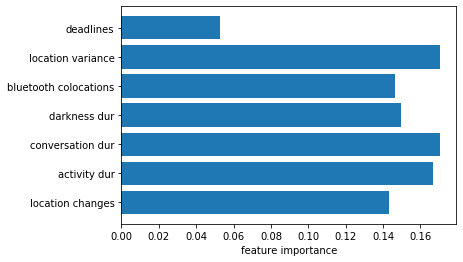

In [35]:
random_forest_importance(x[feature_names_].values, x[['picture_idx']].values, feature_names_, True, True)


In [27]:
def plot_feature_importance(n_features, features_names, feature_importance): 
    """
    input: n_features: number of features
           features_names: names of features
           feature_importance: the importance of each feature
    makes a bar plot showing the importance of each feature. 
    """
    plt.barh(range(n_features), feature_importance, align='center')
    plt.yticks(np.arange(n_features), features_names)
    plt.xlabel('feature importance')

In [24]:
from sklearn.utils import shuffle
def find_cv_scores(uid, window, ema, desired_column, data = None): 
    """
    inputs: uid -- user id
            window -- timeframe to examine
            plot -- if true, plots results
            cv -- if true, returns cross validation scores from stress prediction. 
            
    Finds the intervals of stress around the ema response within the window, predicts stress with those sensor data. 
    returns the feature importance of that stress prediction along with the feature names. 
    """
    
    # load intervals
    if data is None: 
        data = ema_intervals_data(uid, window, ema, desired_column)
    #data = ema_intervals_data(uid, window, ema, desired_column)
            
    feature_names = ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines']
    
    features = data[feature_names].values
    
    target = data[desired_column].values
    
    #features, target = shuffle(features, target, random_state=0)
    
    #feat_import = perm_importance(features, target, feature_names, plot) 
    feat_import = random_forest_importance(features, target, feature_names, plot=False, cv=True)
    
    return feat_import #feature_names    

In [25]:
find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


0.3217391304347826

In [26]:
def average_cv_scores(uid, window, ema, desired_column, data = None):
    cvs = []
    uid = []
    for i in range(0,10):
        cvs.append(find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None))
        uid.append(uid)
    df = pd.DataFrame({'cv': cvs, 'uid': uid})
    return df

In [27]:
def func():
    '''
    x_1 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_2 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_3 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_4 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_5 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_6 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_7 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_8 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_9 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)
    x_10 = find_cv_scores('u07', 2, 'PAM', 'picture_idx', data = None)

    x_list = [x_1, x_2, x_3, x_4, x_5, x_6, x_7, x_8, x_9, x_10]
    x_avg = (sum(x_list))/(len(x_list))
    x_avg
    '''
    return x_avg

In [28]:
def find_window_cvs(uid, windows, ema, desired_column, data, feature_names, plot=False): 
    """
    input: uid -- user id
           windows -- list of windows to look at 
           plot -- boolean that, if true, plots results
           data -- interval data
    
    This function loops through all the windows and finds cross validation scores for stress prediction using the 
    window of time sensors. 
    
    Returns a row of a dataframe corresponding to the maximimum cross validation value and its window of time. 
    """
    
    df = pd.DataFrame()
    # loop through all the windows
    for window in windows: 
        # this function returns the cross validation of the uid's stress EMA for the given window i
        need = data[data['window'] == window]
        cv = find_cv_scores(uid, window, ema, desired_column, feature_names, need)[0]
        # add the window and cv score to a dataframe
        df = df.append(pd.DataFrame({'window': window, 'cross validation score': cv}, index = [0]))
    
    # this will make a scatter of the dataframe
    if plot is True: 
        sns.relplot(x='window', y = 'cross validation score', data = df)
    
    # return the row 
    return df

In [29]:
def optimize_windows(windows, ema, desired_column, data, feature_names): 
    """
    input: windows -- list of windows to look at. 
    
    Loops through all user ids and finds the best (highest cv score) window out of the windows list 
    
    returns a dataframe with each uid and its optimal window with cross validation score. 
    """   
    
    df = pd.DataFrame()
    
    ema_files = glob.glob('dataset/dataset/EMA/response/' + ema + '/' + ema + '_*.json')
    uid_start = len('dataset/dataset/EMA/response/' + ema + '/' + ema + '_')
    # loops through all the files and averages the feature importance lists
    for file in ema_files: 
        # the uid indexed from the file text
        uid = file[uid_start:uid_start+3]
        if uid == 'u00':
            continue
        #uid.remove('u00')
        # if there aren't enough datapoints, the max_window function will throw an error, so I used a try except loop.
        need = data[data['uid'] == uid]
        x = find_window_cvs(uid, windows, ema, desired_column, need, feature_names)
        x['uid'] = uid
        max_window = x[x['cross validation score'] == x['cross validation score'].max()]
        df = df.append(max_window, ignore_index = True)
        break
    
    return df

In [30]:
def search_best_windows(best_windows, feature_names, data, desired_column): 
    """
    inputs: 
        best_windows: dataframe containing uid and the best window for each uids
    outputs: 
        new best parameters and cross validation scores in a dataframe created from random parameter searching the random 
        forest models. 
    """    
    results = pd.DataFrame()  
    for uid in best_windows['uid'].unique(): 
        values = best_windows[best_windows['uid'] == uid].iloc[0]
        window = values['window']
        
        need = data[data['uid'] == uid]
        need = need[need['window'] == window]
        features = need[feature_names].values
        target = need[desired_column].values
        
        best_params, best_score = forest_gridsearch(features, target)
        best_params['score'] = [best_score]
        best_params['uid'] = [uid]
        best_params['window'] = [window]
        results = results.append(pd.DataFrame(best_params), ignore_index=True)
    
    return results

In [31]:
from sklearn.model_selection import RandomizedSearchCV
def forest_gridsearch(features, target): 
    """
    adapted from 
    https://towardsdatascience.com/hyperparameter-tuning-the-random-forest-in-python-using-scikit-learn-28d2aa77dd74
    performs a random parameter search on the random forest model and returns the best parameters and best score. 
    """
    # Number of trees in random forest
    n_estimators = [x*100 for x in range(1, 10)]
    # Number of features to consider at every split
    max_features = ['auto', 'sqrt']
    # Maximum number of levels in tree
    max_depth = [x*10 for x in range(1, 10)]
    max_depth.append(None)
    # Minimum number of samples required to split a node
    min_samples_split = [2, 5, 10]
    # Minimum number of samples required at each leaf node
    min_samples_leaf = [1, 2, 4]
    # Method of selecting samples for training each tree
    bootstrap = [True, False]
    # Create the random grid
    random_grid = {'n_estimators': n_estimators,
                   'max_features': max_features,
                   'max_depth': max_depth,
                   'min_samples_split': min_samples_split,
                   'min_samples_leaf': min_samples_leaf,
                   'bootstrap': bootstrap}
    
    # Use the random grid to search for best hyperparameters
    # First create the base model to tune
    rf = RandomForestClassifier()
    # Random search of parameters, using 3 fold cross validation, 
    # search across 100 different combinations, and use all available cores
    rf_random = RandomizedSearchCV(estimator = rf, param_distributions = random_grid, n_iter = 100, 
                                   cv = 3, verbose=2, random_state=42, n_jobs = -1)
    # Fit the random search model
    rf_random.fit(features, target)
    
    return rf_random.best_params_, rf_random.best_score_

In [32]:
def aggregate_data(windows, ema, desired_column, before = False):
    df = pd.DataFrame()
    
    ema_files = glob.glob('dataset/dataset/EMA/response/' + ema + '/' + ema + '_*.json')
    uid_start = len('dataset/dataset/EMA/response/' + ema + '/' + ema + '_')
    # loops through all the files and averages the feature importance lists
    for file in ema_files: 
        uid = file[uid_start:uid_start+3]
        if uid not in {'u01'}: 
            continue
        for window in windows:
            try:
                data = ema_intervals_data(uid, window, ema, desired_column)
            except:
                continue
            if data is None:
                continue
            data['uid'] = uid
            data['window'] = window
            df = df.append(data)

    return df 

In [33]:
ema_files = glob.glob('dataset/dataset/EMA/response/' + 'PAM' + '/' + 'PAM' + '_*.json')
uid_start = len('dataset/dataset/EMA/response/' + 'PAM' + '/' + 'PAM' + '_')
    # loops through all the files and averages the feature importance lists
for file in ema_files: 
    uid = file[uid_start:uid_start+3]
uid

'u31'

In [34]:
def find_best_funcs(windows, ema, desired_column, feature_names): 
    
    data = aggregate_data(windows, ema, desired_column)
    best_windows = optimize_windows(windows, ema, desired_column, data)
    best_funcs = search_best_windows(best_windows, feature_names, data, desired_column)
    
    return best_funcs, data

In [35]:
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split

def perm_importance(features, target, n_estimators, min_samples_split, min_samples_leaf, max_features, 
                   max_depth, bootstrap): 
    """
    input: features: features of the machine learning model
           target: labels for the machine learning model
           features_names: the name of each feature column 
           plot: boolean, if True, plot the important features
    
    uses permutation importance with a time series split to return the average feature importance for each split along with 
    the standard deviation of that feature importance
    """
    
    tscv = TimeSeriesSplit(n_splits = 5)
    
    avg_importance = zeros(7)
    avg_std = zeros(7)
    
    for train_index, test_index in tscv.split(features): 
            
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]
    
        model = RandomForestClassifier(n_estimators=n_estimators, min_samples_split=min_samples_split,
                                      min_samples_leaf=min_samples_leaf, max_features=max_features,
                                      max_depth=max_depth, bootstrap=bootstrap)
        model.fit(X_train, y_train)
        
        #print('prediction: {}'.format(model.predict(X_test)))
        #print('acutal: {}'.format(y_test))
        
        r = permutation_importance(model, X_test, y_test, n_repeats = 30, random_state = 0)
        
        avg_importance = avg_importance + r.importances_mean/5
        avg_std = avg_std + r.importances_std/5
            
        print(r.importances_mean)
        print(r.importances_std)
    
    return avg_importance, avg_std

ImportError: cannot import name 'permutation_importance' from 'sklearn.inspection' (/opt/anaconda3/lib/python3.7/site-packages/sklearn/inspection/__init__.py)

In [36]:
def find_all_feature_importance(windows, ema, desired_column, feature_names): 
    feature_names = ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines']
    best_functions, data = find_best_funcs(windows, ema, desired_column, feature_names)

    corr = data.corr()
    ax = sns.heatmap(
        corr, 
        vmin=-1, vmax=1, center=0,
        #cmap=sns.diverging_palette(20, 220, n=200),
        square=True
    )
    
    ax.set_xticklabels(
        ax.get_xticklabels(),
        rotation=45,
        horizontalalignment='right'
    )
    
    return data.corr()

    feat_imp_df = pd.DataFrame()
    for i in best_functions.index:
        row = best_functions.iloc[i]
        n_estimators = row['n_estimators']
        min_samples_split = row['min_samples_split']
        min_samples_leaf = row['min_samples_leaf']
        max_features = row['max_features']
        max_depth = row['max_depth']
        bootstrap = row['bootstrap']
        viewing = data[data['uid'] == row['uid']]
        viewing = viewing[viewing['window'] == row['window']]
        features = viewing[feature_names].values
        target = viewing[desired_column].values
        feat_importance = random_forest_importance(features, target, features_names, plot, cv)
        feat_imp_df = feat_imp_df.append(pd.DataFrame({'uid': row['uid'], 'importance': feat_importance[0], 
                                                      'std': feat_importance[1], 'sensor': feature_names}))
        
    return feat_imp_df

In [37]:
#find_all_feature_importance([5], 'stress', 'level')

In [38]:
find_all_feature_importance([5], 'PAM', 'picture_idx')

TypeError: find_all_feature_importance() missing 1 required positional argument: 'feature_names'

In [39]:
#find_all_feature_importance([5], 'sleep', 'rate')

In [40]:
def tscvscore(features, target, model, n_splits): 
    tscv = TimeSeriesSplit(n_splits = 5)
    avg_score = 0
        
    for train_index, test_index in tscv.split(features): 
        X_train, X_test = features[train_index], features[test_index]
        y_train, y_test = target[train_index], target[test_index]
            
       
        model.fit(X_train, y_train)
        score = model.score(X_test, y_test)
        #print("train indices: {}, test indices: {}, score: {:.2f}".format(train_index, test_index, score))
        #print("predictions: {}, actual: {}".format(model.predict(X_test), target[test_index]))
        avg_score += score/5
            
    return avg_score

In [41]:
def uid_list(ema_name):
    ema_files = glob.glob('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name + '_*.json')
    uid_start = len('dataset/dataset/EMA/response/' + ema_name + '/' + ema_name + '_')
    deadlines_uid = list(deadlines_data.columns)
    deadlines_uid = deadlines_uid[:-1]
    uid_list = []
    for file in ema_files:
        uid = file[uid_start:uid_start+3]
    
        if uid == 'u24':
            #emas = pd.read_json(file)
            uid_list.append(uid)
            continue
        
        uid_list.append(uid)
    
    uid_list = [i for i in deadlines_uid if i in uid_list]
    return uid_list

In [42]:
len(uid_list("PAM"))

44

In [43]:
from sklearn.ensemble import ExtraTreesClassifier

def validate_user(uid, window, ema_name, desired_column, feature_names):
    
    data = ema_intervals_data(uid, window, ema_name, desired_column)
    features = data[feature_names].values
    target = data[desired_column].values
    
    extra_trees = ExtraTreesClassifier()
    random_forest = RandomForestClassifier()
    
    et_scores = []
    rf_scores = []
    
   
    for i in range(10): 
    
        et_scores.append(tscvscore(features, target, extra_trees, 5))
        rf_scores.append(tscvscore(features, target, random_forest, 5))
                         
    cor_et_scores = []
    cor_rf_scores = []
    
    for i in range(10): 
        
        np.random.shuffle(target)
    
        cor_et_scores.append(tscvscore(features, target, extra_trees, 5))
        cor_rf_scores.append(tscvscore(features, target, random_forest, 5))

    
    
    return pd.DataFrame({'et score': et_scores, 
                         'rf score': rf_scores, 
                         'corrupted et score': cor_et_scores, 
                         'corrupted rf score': cor_rf_scores, 
                         'uid': uid, 
                         'window': window})

In [44]:
def validate_user_v2(uid, window, ema_name, desired_column, feature_names):
   
    data = ema_intervals_data(uid, window, ema_name, desired_column)
    features = data[feature_names].values
    target = data[desired_column].values
    
    extra_trees = ExtraTreesClassifier()
    random_forest = RandomForestClassifier()
    
    et_scores = []
    rf_scores = []
    
   
    for i in range(10): 
    
        et_scores.append(tscvscore(features, target, extra_trees, 5))
        rf_scores.append(tscvscore(features, target, random_forest, 5))
                         
    cor_et_scores = []
    cor_rf_scores = []
    
    for i in range(10): 
        
        np.random.shuffle(target)
    
        cor_et_scores.append(tscvscore(features, target, extra_trees, 5))
        cor_rf_scores.append(tscvscore(features, target, random_forest, 5))

    scores_df = pd.DataFrame({'et score': et_scores, 
                              'rf score': rf_scores, 
                              'corrupted et score': cor_et_scores, 
                              'corrupted rf score': cor_rf_scores, 
                              'uid': uid, 
                              'window': window})
    
    rf_p_value = scipy.stats.ttest_ind(scores_df['rf score'], scores_df['corrupted rf score'])[1]
    et_p_value = scipy.stats.ttest_ind(scores_df['et score'], scores_df['corrupted et score'])[1]
    
    if rf_p_value >= et_p_value: 
        return rf_p_value/2, scores_df[['rf score', 'corrupted rf score', 'uid', 'window']], 'rf'
    else: 
        return et_p_value/2, scores_df[['et score', 'corrupted et score', 'uid', 'window']], 'et'

In [45]:
features = ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines']

In [46]:
def get_all_scores(window, ema_name, desired_column, feature_names):
    uids = uid_list(ema_name)
    uids.remove('u09')
    uids.remove('u13')
    user_score_df = pd.DataFrame()
    
    for i in range(len(uids)):
        
        if i == 0:
            uid = uids[i]
            window = window
            ema_name = ema_name
            desired_column = desired_column
            feature_names = feature_names
            user_score_df = validate_user(uid, window, ema_name, desired_column, ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines'])
    
        else:
            try:
                uid = uids[i]
                window = window
                ema_name = ema_name
                desired_column = desired_column
                feature_names = feature_names
                user_score_df = user_score_df.append(validate_user(uid, window, ema_name, desired_column, ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines']))
            except ValueError: 
                pass
    return user_score_df

In [60]:
def get_all_scores_v2(window, ema_name, desired_column, feature_names):
    uids = uid_list(ema_name)
    uids.remove('u09')
    uids.remove('u13')
    user_score_df = pd.DataFrame()
    results_df = pd.DataFrame()
    windows = [2,4,6,8,10]
    
    for i in range(len(uids)):
        
        if i == 0:
            for j in windows:
                uid = uids[i]
                window = j
                ema_name = ema_name
                desired_column = desired_column
                feature_names = feature_names
                p, scores_df, best_model = validate_user_v2(uid, window, ema_name, desired_column, features)
                scores_df['diff'] = scores_df['{} score'.format(best_model)] - scores_df['corrupted {} score'.format(best_model)]
                results_df = results_df.append(pd.DataFrame({'p-value': [p], 
                                                     'avg difference': [scores_df['diff'].mean()], 
                                                     'avg score': [scores_df['{} score'.format(best_model)].mean()],
                                                     'best model': best_model,
                                                     'uid': uid,
                                                     'window': window}))
    
        else:
            try:
                for j in windows:
                    uid = uids[i]
                    window = j
                    ema_name = ema_name
                    desired_column = desired_column
                    feature_names = feature_names
                    p, scores_df, best_model = validate_user_v2(uid, window, ema_name, desired_column, features)
                    scores_df['diff'] = scores_df['{} score'.format(best_model)] - scores_df['corrupted {} score'.format(best_model)]
                    results_df = results_df.append(pd.DataFrame({'p-value': [p], 
                                                     'avg difference': [scores_df['diff'].mean()], 
                                                     'avg score': [scores_df['{} score'.format(best_model)].mean()],
                                                     'best model': best_model,
                                                     'uid': uid,
                                                     'window': window}))
            except ValueError: 
                pass

    return results_df

In [49]:
df_all = get_all_scores(2, 'PAM', 'picture_idx', ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

KeyboardInterrupt: 

In [61]:
df_all_v2 = get_all_scores_v2(2, 'PAM', 'picture_idx', features)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: F

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: Setting

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: Setting

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_in

In [62]:
df_all_v2

,p-value,avg difference,avg score,best model,uid,window
0,0.001173,0.073333,0.342857,rf,u01,2
0,0.354836,-0.007619,0.271429,rf,u01,4
0,0.453440,-0.001818,0.290000,rf,u01,6
0,0.468794,0.001818,0.280909,et,u01,8
0,0.044360,-0.022727,0.252727,rf,u01,10
...,...,...,...,...,...,...
0,0.264555,0.004638,0.343478,et,u59,2
0,0.041130,0.018551,0.353623,et,u59,4
0,0.239647,0.006957,0.365797,et,u59,6
0,0.007626,0.033043,0.360000,rf,u59,8


In [90]:
x = df_all_v2.groupby('uid')['p-value'].min()
df_pvalue = pd.merge(df_all_v2, x, on='p-value', how='inner')

In [96]:
df_pvalue.groupby('best model').size()

best model
et    12
rf    28
dtype: int64

In [95]:
df_all_v2.groupby('window')['avg difference'].mean()
#maybe check to see if window duration is affected by PHQ-9 scores?

window
2     0.004597
4    -0.000537
6     0.000624
8     0.001016
10   -0.015073
Name: avg difference, dtype: float64

In [77]:
df_all_v2_max = df_all_v2.groupby('uid')['avg score'].max()

In [85]:
df_merged = pd.merge(df_all_v2, df_all_v2_max, on='avg score', how = 'inner')

In [97]:
df_merged.groupby('window').size()

window
2     11
4      8
6     12
8      9
10     4
dtype: int64

In [68]:
df_all_v2_max

uid
u01    0.342857
u02    0.329444
u03    0.308235
u04    0.267647
u05    0.166667
u07    0.343478
u08    0.305641
u10    0.362857
u12    0.345517
u14    0.365000
u15    0.355000
u16    0.288421
u17    0.525294
u18    0.351304
u19    0.420645
u20    0.384000
u22    0.306667
u23    0.425600
u24    0.331429
u25    0.397143
u27    0.291034
u30    0.361176
u31    0.246667
u32    0.361818
u33    0.280000
u34    0.288571
u35    0.365455
u41    0.321667
u42    0.565263
u44    0.338333
u45    0.310000
u46    0.342000
u47    0.347500
u49    0.308750
u50    0.420000
u52    0.352571
u53    0.306857
u54    0.284286
u58    0.394400
u59    0.365797
Name: avg score, dtype: float64

In [58]:
df_all_v2

,p-value,avg difference,avg score,best model,uid
0,0.126350,0.019048,0.324762,et,u01
0,0.099096,0.016667,0.306111,et,u02
0,0.106700,0.017647,0.280000,et,u03
0,0.430620,0.002353,0.275294,et,u04
0,0.000007,-0.193333,0.120000,et,u05
0,0.174873,0.019130,0.317391,et,u07
0,0.244357,-0.007692,0.244103,rf,u08
0,0.013852,0.030612,0.361224,rf,u10
0,0.196406,0.012143,0.336429,rf,u12
0,0.001940,-0.047742,0.342581,rf,u14


In [43]:
df_all = df_all.groupby('uid').mean()

In [44]:
df_all

,et score,rf score,corrupted et score,corrupted rf score,window
uid,,,,,
u01,0.345714,0.364762,0.275238,0.278095,2
u02,0.304444,0.303333,0.291111,0.270556,2
u03,0.282353,0.297647,0.251765,0.256471,2
u04,0.267059,0.277647,0.265882,0.262941,2
u05,0.106667,0.160000,0.286667,0.313333,2
u07,0.300000,0.321739,0.300000,0.309565,2
u08,0.241538,0.242564,0.266667,0.248205,2
u10,0.362857,0.367755,0.311837,0.325714,2
u12,0.330714,0.352143,0.322143,0.343571,2


In [63]:
df_all.describe()

,et score,rf score,corrupted et score,corrupted rf score,window
count,40.000000,40.000000,40.000000,40.000000,40.0
mean,0.322192,0.324740,0.316628,0.320437,2.0
std,0.059544,0.058960,0.067841,0.068094,0.0
min,0.126667,0.140000,0.201667,0.205714,2.0
25%,0.279160,0.289892,0.271324,0.271138,2.0
50%,0.330194,0.333667,0.302312,0.310996,2.0
75%,0.354829,0.357219,0.340435,0.357938,2.0
max,0.458947,0.451765,0.529474,0.510526,2.0


In [169]:
def validate_users(window, ema_name, desired_column, feature_names):
    
    uids = uid_list(ema_name)
    uids.remove('u09')
    uids.remove('u13')
    
    for i in uids:
        data = ema_intervals_data(i, window, ema_name, desired_column)
        features = data[feature_names].values
        target = data[desired_column].values
    
        extra_trees = ExtraTreesClassifier()
        random_forest = RandomForestClassifier()
    
        et_scores = []
        rf_scores = []
        uid = []
    
   
        for i in range(10): 
    
            et_scores.append(tscvscore(features, target, extra_trees, 5))
            rf_scores.append(tscvscore(features, target, random_forest, 5))
            uid.append(i)
                         
        cor_et_scores = []
        cor_rf_scores = []
    
        for i in range(10): 
        
            np.random.shuffle(target)
    
            cor_et_scores.append(tscvscore(features, target, extra_trees, 5))
            cor_rf_scores.append(tscvscore(features, target, random_forest, 5))

    
    
    return pd.DataFrame({'et score': et_scores, 
                         'rf score': rf_scores, 
                         'corrupted et score': cor_et_scores, 
                         'corrupted rf score': cor_rf_scores, 
                         'uid': uid, 
                         'window': window})

In [170]:
validate_users(6, 'PAM', 'picture_idx', feature_names_)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemble/forest.py:245: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)
/opt/anaconda3/lib/python3.7/site-packages/sklearn/ensemb

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


TypeError: 'NoneType' object is not subscriptable

In [136]:
def validate_users_1(window, ema_name, desired_column, feature_names):
    
    uids = uid_list('PAM')
    trueornot = []
    uid = []
    for i in uids:
        uid.append(i)
        data = ema_intervals_data(i, window, ema_name, desired_column)
        if type(data) == type(None):
            trueornot.append(False)
        else:
            trueornot.append(True)
        #target = data[desired_column].values
    df = pd.DataFrame({'uid': uid, 'type': trueornot})
    return df

In [137]:
features = ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines']

In [138]:
validate_users_1(6, 'PAM', 'picture_idx', features)

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


,uid,type
0,u01,True
1,u02,True
2,u03,True
3,u04,True
4,u05,True
5,u07,True
6,u08,True
7,u09,False
8,u10,True
9,u12,True


In [118]:
def validate_users(window, ema_name, desired_column, feature_names):
    uids = uid_list(ema_name)
    list_ids = uids.remove('u00')
    return list_ids

In [119]:
validate_users(6, 'PAM', 'picture_idx', feature_names_)

In [122]:
uids = uid_list('PAM')
uids.remove('u00')

In [81]:
def validate_all_users(windows, ema_name, desired_column, feature_names, before=False):
    
    data = aggregate_data(windows, ema_name, desired_column, before)
    
    best_windows = optimize_windows(windows, ema_name, desired_column, data, feature_names)
    
    results_df = pd.DataFrame()
    
    for uid in data.uid.unique(): 
        
        best_window = best_windows[best_windows.uid == uid].iloc[0].window
        
        custom_data = data[data.uid == uid]
        custom_data = custom_data[custom_data.window == best_window]
    
        p, scores_df, best_model = validate_user(uid, best_window, ema_name, desired_column, feature_names, custom_data)
        
        scores_df['diff'] = scores_df['{} score'.format(best_model)] - scores_df['corrupted {} score'.format(best_model)]
        
        # consider p/2 since we only care about if the model is greater than random
        results_df = results_df.append(pd.DataFrame({'p-value': [p], 
                                                     'avg difference': [scores_df['diff'].mean()], 
                                                     'avg score': [scores_df['{} score'.format(best_model)].mean()],
                                                     'best model': best_model,
                                                     'uid': uid,
                                                     'window': best_windows[best_windows.uid == uid].iloc[0].window}))
    return results_df

In [82]:
validate_all_users([2, 4, 6, 8, 10, 12], 'PAM', 'picture_idx', ['activity dur', 'conversation dur', 'darkness dur',
                                 'bluetooth colocations', 'location variance', 'location changes', 'deadlines'])

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:39: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


ValueError: Found array with 0 sample(s) (shape=(0, 7)) while a minimum of 1 is required.